## Analyze whether SNWD varies more from year to year or from place to place.

In [40]:
import pandas as pd
import numpy as np
import urllib
import math

In [41]:
import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [42]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [43]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBSBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
710


In [44]:
print df.columns

['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'label', 'latitude', 'longitude', 'measurement', 'res_1', 'res_2', 'res_3', 'res_mean', 'station', 'total_var', 'undefs', 'vector', 'year']


In [45]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
Features='station, year, coeff_3'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_3 FROM weather


,station,year,coeff_3
0,USC00427165,2008.0,-197.536959
1,USC00426869,1982.0,-142.781893
2,USC00426869,2010.0,-324.019349
3,USC00426869,1973.0,1364.208989
4,USC00426869,1971.0,1679.914945


In [46]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_3')
year_station_table.head(10)
#print type(year_station_table)

station,USC00100803,USC00103732,USC00105275,USC00106053,USC00107346,USC00107353,USC00420487,USC00420924,USC00420928,USC00421590,...,USC00427271,USC00427318,USC00428828,USC00428885,USC00429346,USC00429595,USC00480915,USW00024101,USW00024120,USW00024126
year,,,,,,,,,,,,,,,,,,,,,
1929.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-140.258860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1930.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1931.0,NaN,NaN,NaN,-168.280743,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-638.016128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1932.0,NaN,NaN,NaN,-66.068383,NaN,NaN,NaN,NaN,NaN,NaN,...,-339.164592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1933.0,NaN,NaN,NaN,-331.158161,NaN,NaN,NaN,NaN,NaN,NaN,...,-166.527622,-720.333907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1935.0,NaN,NaN,232.794966,-258.676637,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1936.0,NaN,NaN,1037.332703,-395.383078,NaN,NaN,NaN,NaN,NaN,NaN,...,-266.319656,-400.002222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1937.0,NaN,NaN,578.851496,-281.493711,NaN,NaN,NaN,NaN,NaN,NaN,...,-337.983009,-1266.614571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1938.0,NaN,NaN,1.975298,-154.894549,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
Features2='elevation,coeff_3'
Query="SELECT %s FROM weather"%Features2
print(Query)
pdf2 = sqlContext.sql(Query).toPandas()
pdf2.head()
year_station_table2=pdf2.pivot(columns='elevation',values='coeff_3')
year_station_table2.head(10)

SELECT elevation,coeff_3 FROM weather


elevation,1289.3,1302.1,1304.5,1307.6,1324.1,1325.9,1335.0,1341.1,1357.9,1362.5,...,1694.7,1806.2,1806.9,1816.6,1817.8,1822.7,1849.8,1911.1,1924.8,1984.2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-197.536959,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,1446.978622,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-437.063756,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the first eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [48]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print 'total RMS                   = ',RMS(year_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-year   = ',RMS(tbl_minus_year)

total RMS                   =  598.320831818
RMS removing mean-by-station=  545.039058008
RMS removing mean-by-year   =  393.790733512


In [49]:

mean_by_elevation=np.nanmean(year_station_table2,axis=0)
print shape(year_station_table2.transpose())
print shape(year_station_table2-mean_by_elevation)
#tbl_minus_elevation = (year_station_table2.transpose()-mean_by_elevation).transpose()
print RMS(year_station_table2)
print RMS(year_station_table2-mean_by_elevation)

(36, 710)
(710, 36)
598.320831818
548.526790396


Populating the interactive namespace from numpy and matplotlib
initial RMS= 598.320831818
0 after removing mean by year    = 393.790733512
0 after removing mean by stations= 355.119045534
1 after removing mean by year    = 347.908342755
1 after removing mean by stations= 346.000004166
2 after removing mean by year    = 345.381904391
2 after removing mean by stations= 345.150592073
3 after removing mean by year    = 345.055007223
3 after removing mean by stations= 345.013014032
4 after removing mean by year    = 344.993912528
4 after removing mean by stations= 344.98505944


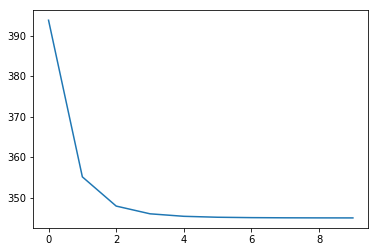

In [50]:
%pylab inline
T=year_station_table
print 'initial RMS=',RMS(T)
pic=[]
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    pic.append(RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)
    pic.append(RMS(T))
plot(pic)

Populating the interactive namespace from numpy and matplotlib
initial RMS= 598.320831818
0 after removing mean by year    = 393.790733512
0 after removing mean by stations= 355.119045534
1 after removing mean by year    = 347.908342755
1 after removing mean by stations= 346.000004166
2 after removing mean by year    = 345.381904391
2 after removing mean by stations= 345.150592073
3 after removing mean by year    = 345.055007223
3 after removing mean by stations= 345.013014032
4 after removing mean by year    = 344.993912528
4 after removing mean by stations= 344.98505944


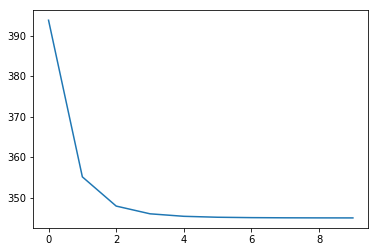

In [51]:
%pylab inline
T=year_station_table
print 'initial RMS=',RMS(T)
pic2=[]
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    pic2.append(RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)
    pic2.append(RMS(T))
plot(pic2)

In [52]:
%pylab inline
T=year_station_table
print 'initial RMS=',RMS(T)
pic3=[]
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    pic3.append(RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)
    pic3.append(RMS(T))

Populating the interactive namespace from numpy and matplotlib
initial RMS= 598.320831818
0 after removing mean by year    = 393.790733512
0 after removing mean by stations= 355.119045534
1 after removing mean by year    = 347.908342755
1 after removing mean by stations= 346.000004166
2 after removing mean by year    = 345.381904391
2 after removing mean by stations= 345.150592073
3 after removing mean by year    = 345.055007223
3 after removing mean by stations= 345.013014032
4 after removing mean by year    = 344.993912528
4 after removing mean by stations= 344.98505944


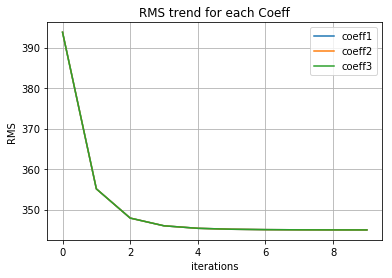

In [53]:
labels_co=['coeff1','coeff2','coeff3']
pics=[pic,pic2,pic3]
for i in range(3):
    plot(pics[i],label=labels_co[i])
    title('RMS trend for each Coeff')
    ylabel('RMS')
    xlabel('iterations')
    legend(loc='upper right')
    grid()

In [54]:
sc.stop()